# Colorize Black Image

[Colorful Image Colorization ](http://arxiv.org/pdf/1603.08511.pdf) 

- The authors embrace the underlying uncertainty of the problem (black and white to color conversion) by posing it as a classification task and use class-rebalancing at training time to increase the diversity of colors in the result. 
- The system is implemented as a feed-forward pass in a CNN at test time and is trained on over a million color images. 
- They evaluate our algorithm using a “colorization Turing test,” asking human participants to choose between a generated and ground truth color image. 
- Their method successfully fools humans on 32% of the trials, significantly higher than previous methods.

![](http://richzhang.github.io/colorization/resources/images/teaser3.jpg)

by Richard Zhang, Phillip Isola, Alexei A. Efros. In ECCV, 2016.

We'll be using the following Caffe model files that we'll download in the next cell below. These will be then loaded into OpenCV:

1. colorization_deploy_v2.prototext
2. colorization_release_v2.caffe
3. pts_in_hull.npy

---
### Imports and Helper-functions

In [10]:
import os
from os import listdir
from os.path import isfile, join
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def imshow(img, title=None, size=10, axis=False, color_space="BGR"):
    aspect_ratio = img.shape[0] / img.shape[1]
    plt.figure(figsize=(size * aspect_ratio, size))
    if color_space.lower() == "bgr":
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_space.lower() == "rgb":
        rgb_img = img
    else:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(rgb_img)
    if type(title) == str:
        plt.title(title)
    if axis == False:
        plt.axis('off')
    plt.show()

In [3]:
def get_random_img_path(search_path='../../res/img', skip=["flickr"]):
    """
    This function searches for common image files in all subdirectories
    and return a random image path of them.
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.ico']
    image_paths = []

    # Walk through all subdirectories
    for root, dirs, files in os.walk(search_path):
        for file_name in files:
            # Check if the file is an image
            if any(file_name.lower().endswith(ext) for ext in image_extensions):
                # Get the full file path
                full_path = os.path.join(root, file_name).replace("\\", "/")
                if not any(i in full_path for i in skip):
                    image_paths.append(full_path)

    return random.choice(image_paths)

# get an image
IMG_PATH = get_random_img_path(skip=["flickr", "weather", "gem", "Cheetahs", "Lions", "chinese_art", "course_img"])
IMG_PATH   

'../../res/img/self/_DSC1263.jpg'

---
### Loading data

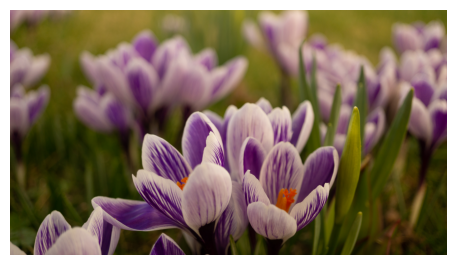

(3376, 6000, 3)

In [13]:
img = cv2.imread(IMG_PATH)
imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img.shape

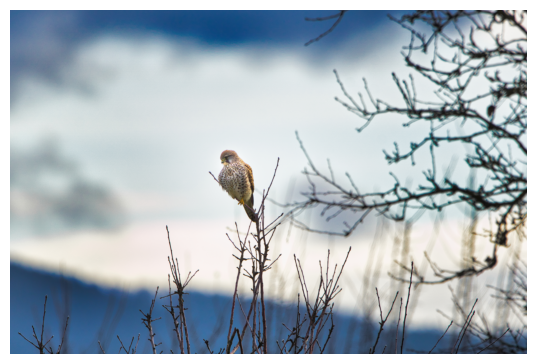

(4000, 6000, 3)

In [5]:
img_2 = cv2.imread(get_random_img_path(skip=["flickr", "weather", "gem", "Cheetahs", "Lions", "chinese_art", "course_img"]))
imshow(img_2)

gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

img_2.shape

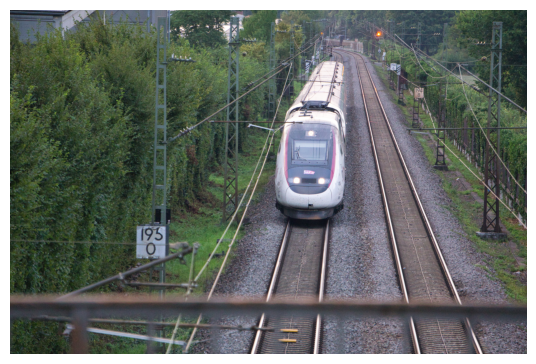

(4000, 6000, 3)

In [8]:
img_3 = cv2.imread(get_random_img_path(skip=["flickr", "weather", "gem", "Cheetahs", "Lions", "chinese_art", "course_img"]))
imshow(img_3)

gray_3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2GRAY)

img_3.shape

---
### Colorize

Script is based on https://github.com/richzhang/colorization/blob/master/colorize.py

To download the caffemodel and the prototxt, see: https://github.com/richzhang/colorization/tree/master/models

To download pts_in_hull.npy, see: https://github.com/richzhang/colorization/blob/master/resources/pts_in_hull.npy

In [14]:
def colorize(img):
    img_rgb = (img[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
    
    # pull out L channel
    img_l = img_lab[:,:,0]
    
    # get original image size
    (H_orig,W_orig) = img_rgb.shape[:2] 

    # resize image to network input size
    img_rs = cv2.resize(img_rgb, (224, 224)) 
    
    # resize image to network input size
    img_lab_rs = cv2.cvtColor(img_rs, cv2.COLOR_RGB2Lab)
    img_l_rs = img_lab_rs[:,:,0]
    
    # subtract 50 for mean-centering
    img_l_rs -= 50 

    net.setInput(cv2.dnn.blobFromImage(img_l_rs))
    
    # this is our result
    ab_dec = net.forward('class8_ab')[0,:,:,:].transpose((1,2,0)) 

    (H_out,W_out) = ab_dec.shape[:2]
    ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
    img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) 
    
    # concatenate with original image L
    img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2BGR), 0, 1)

    # show original image
    imshow(img, 'Original')
    # Resize the corlized image to it's orginal dimensions 
    img_bgr_out = cv2.resize(img_bgr_out, (W_orig, H_orig), interpolation = cv2.INTER_AREA)
    imshow(img_bgr_out, 'Colorized')

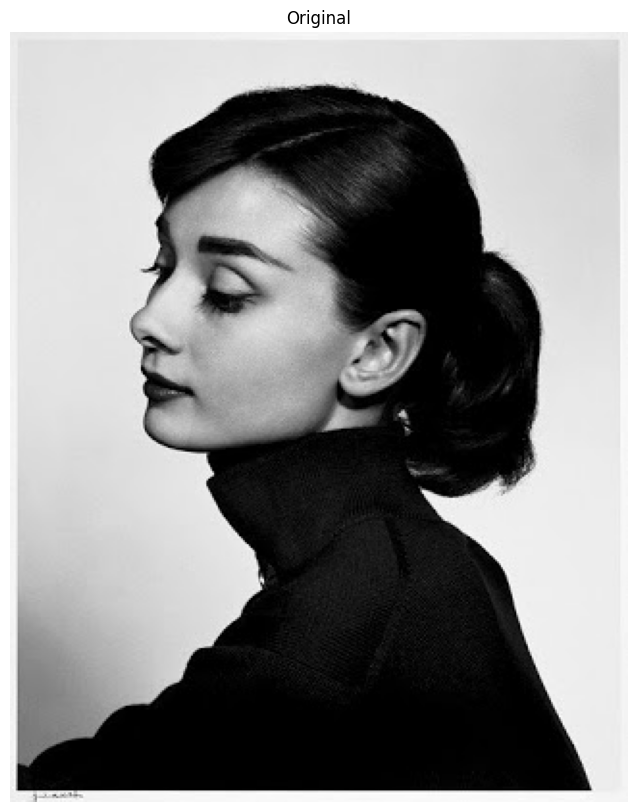

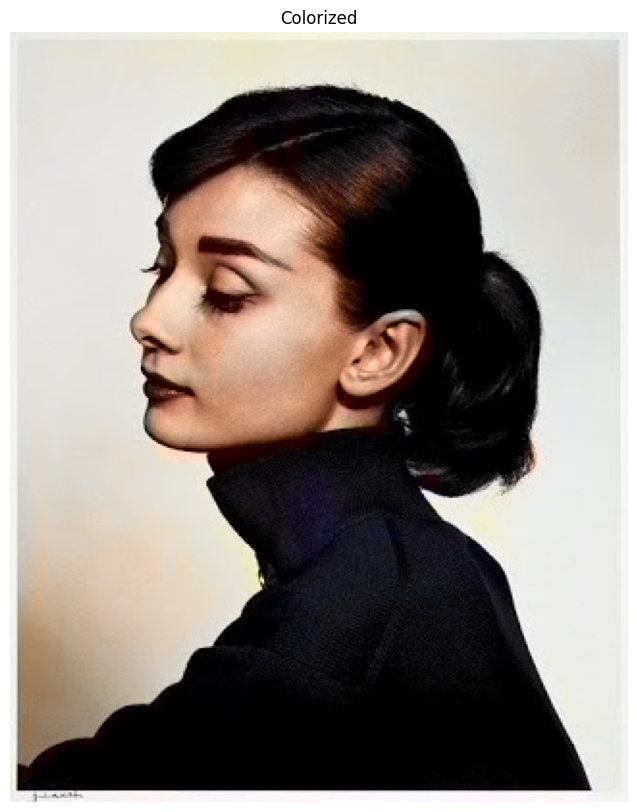

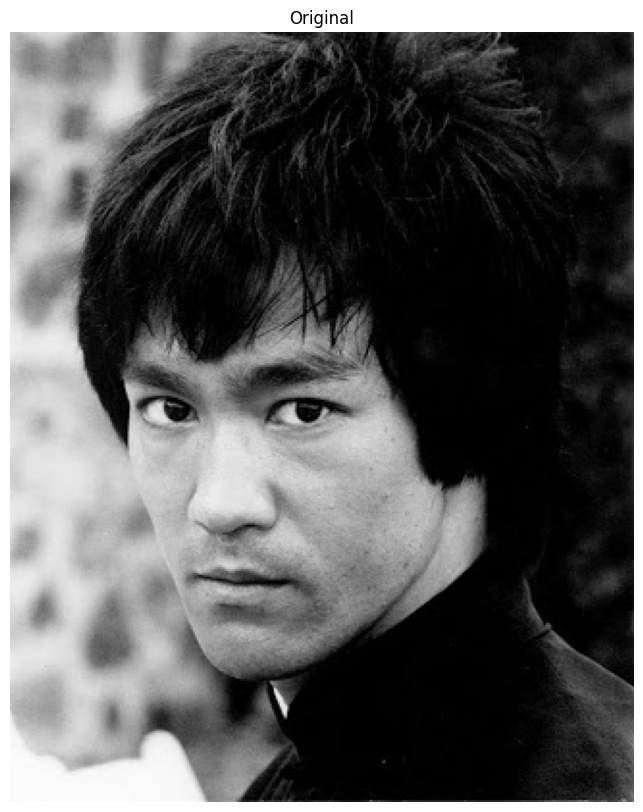

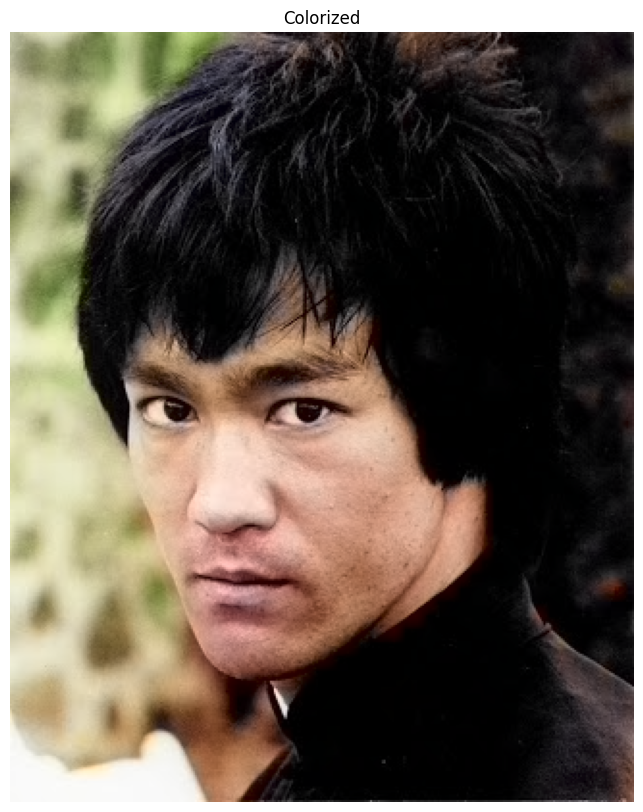

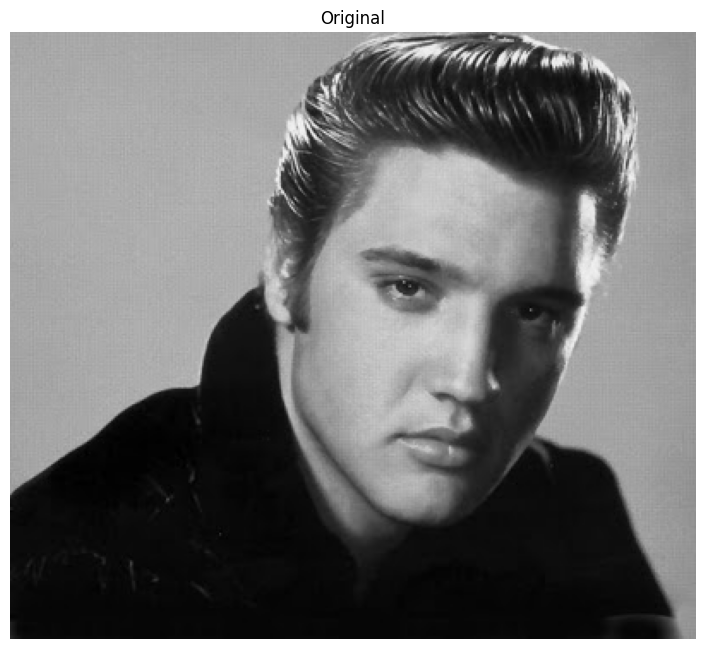

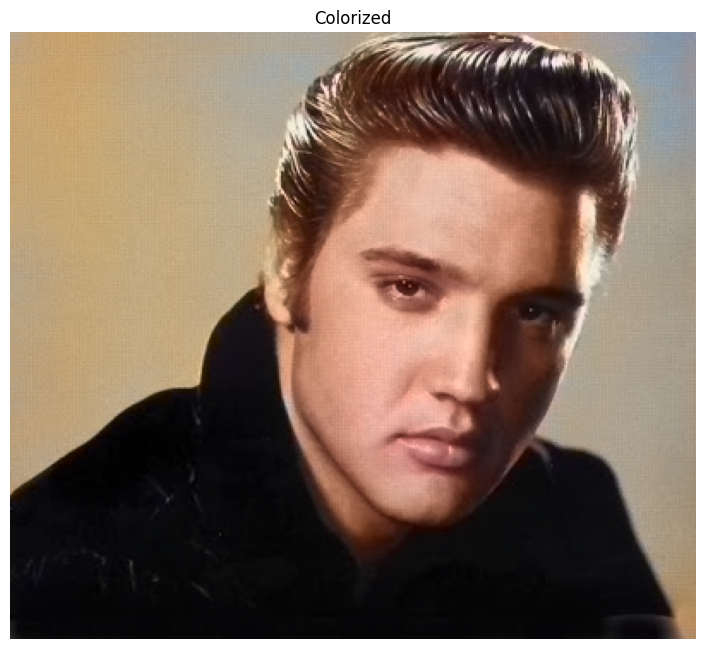

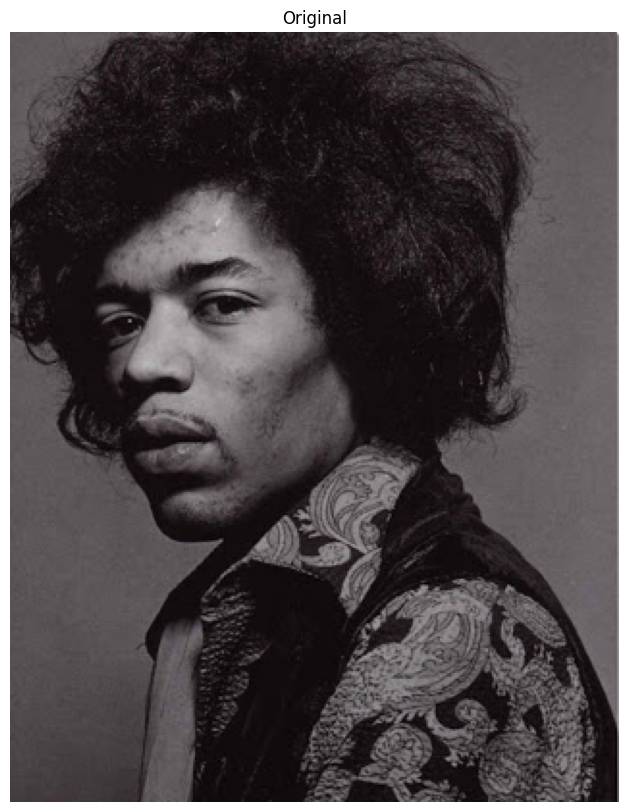

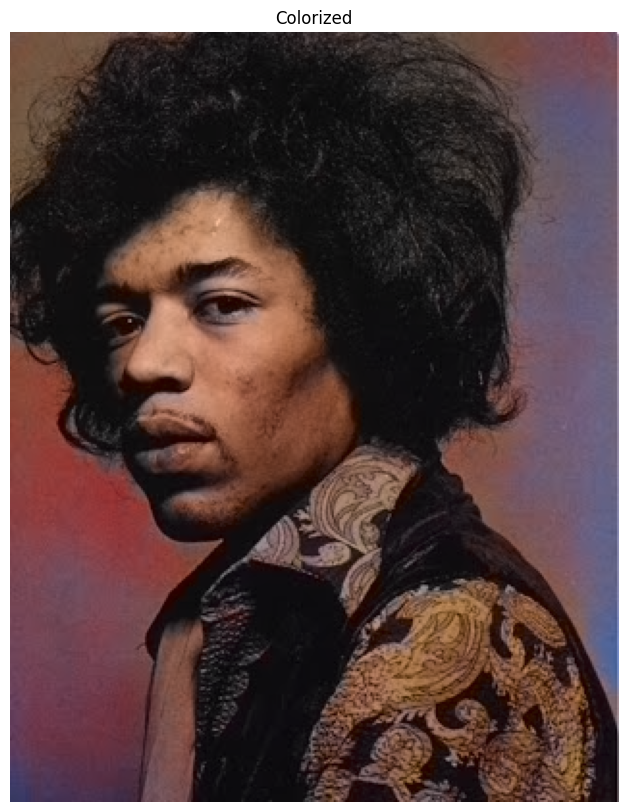

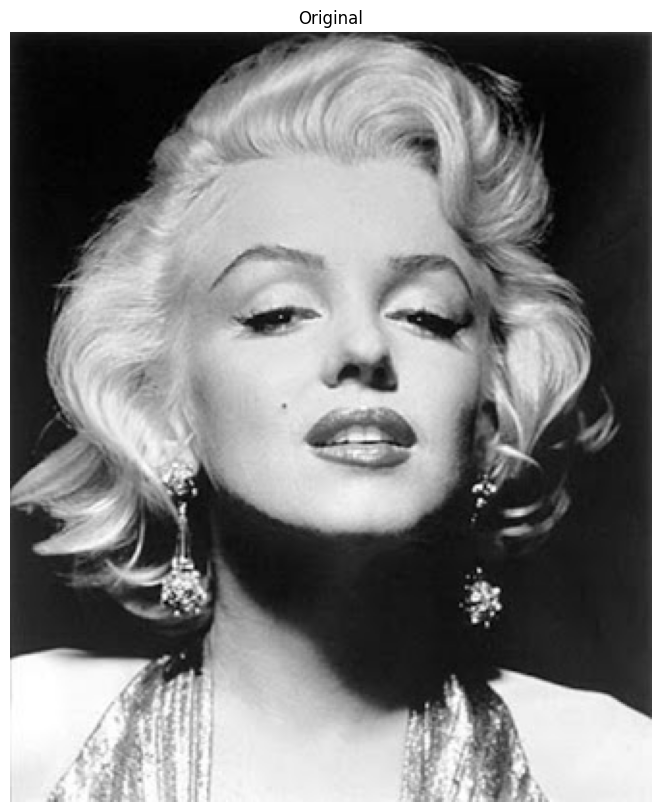

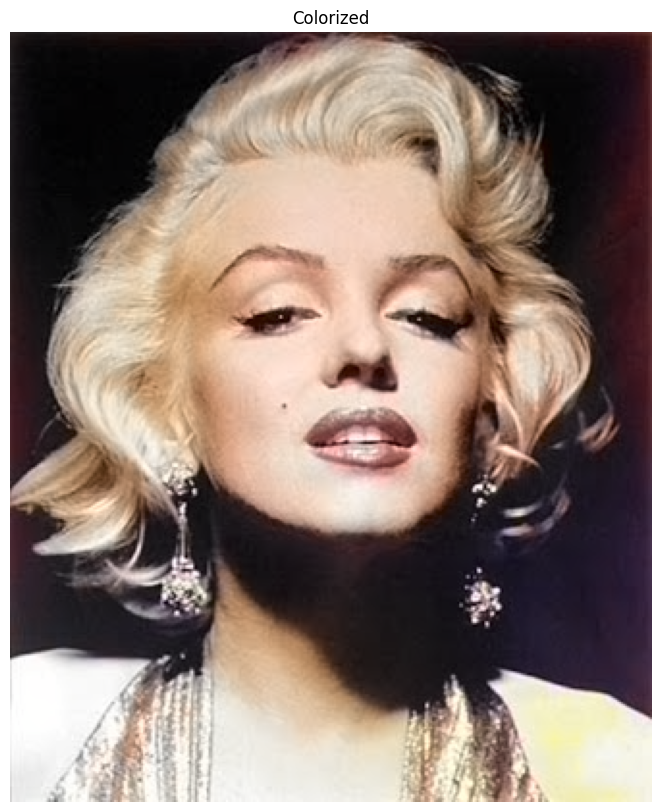

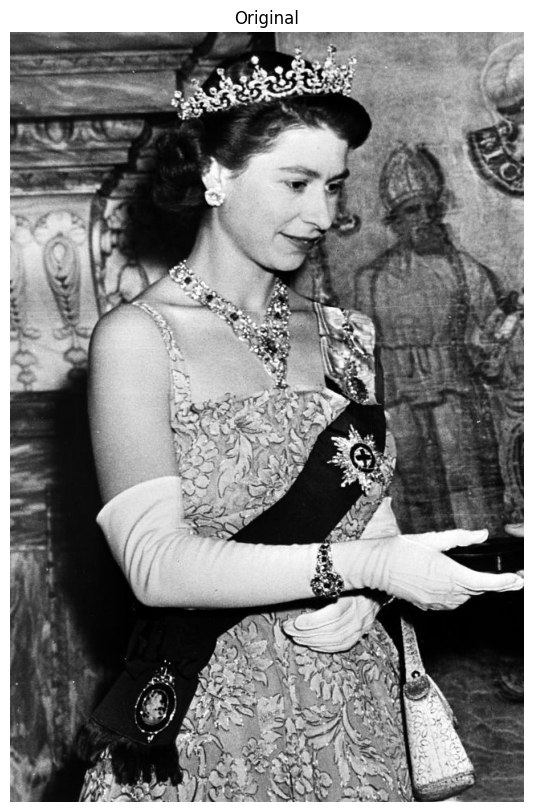

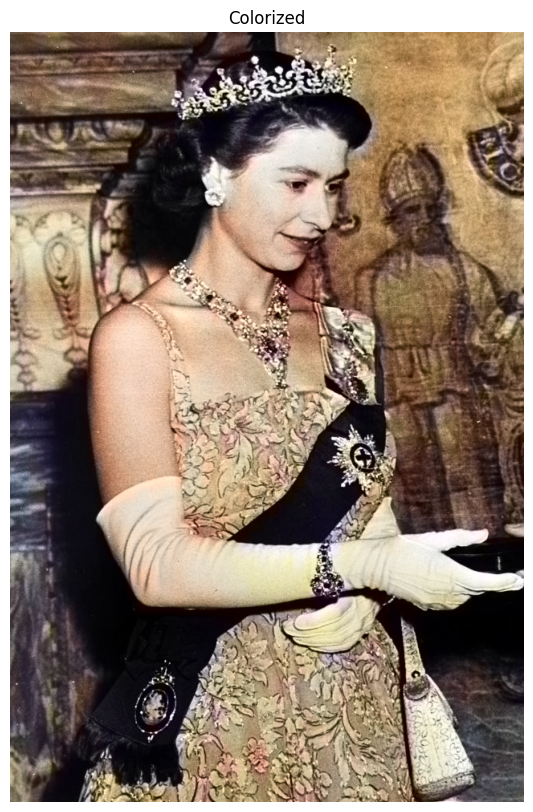

In [15]:
# Get our images
file_path = "../../res/colorize/blackandwhite/"
blackandwhite_imgs = [f for f in listdir(file_path) if isfile(join(file_path, f))]
kernel = '../../res/colorize/pts_in_hull.npy'

# Select desired model
net = cv2.dnn.readNetFromCaffe("../../res/colorize/colorization_deploy_v2.prototxt",
                            "../../res/colorize/colorization_release_v2.caffemodel")

# load cluster centers
pts_in_hull = np.load(kernel) 

# populate cluster centers as 1x1 convolution kernel
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

for image in blackandwhite_imgs:
    colorize(cv2.imread(file_path+image))
    
    

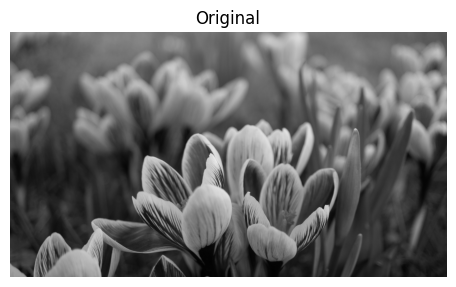

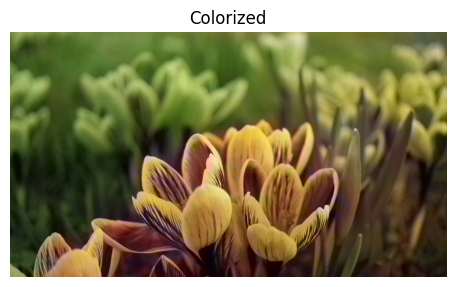

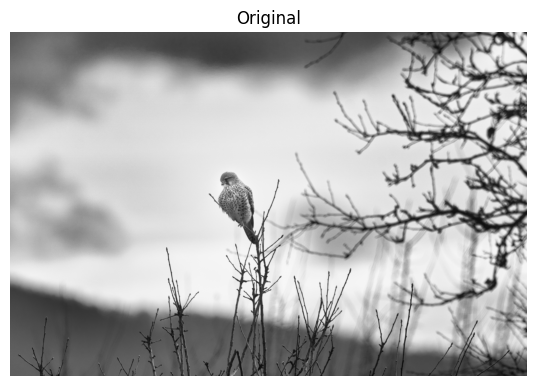

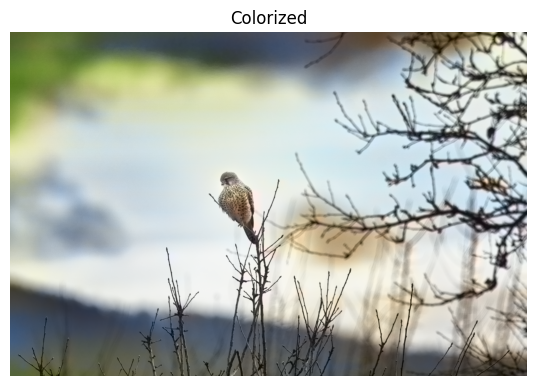

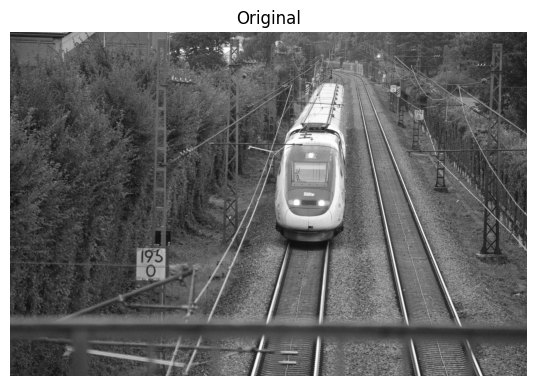

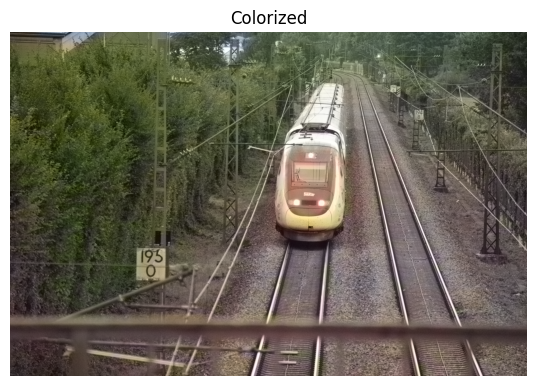

In [19]:
for cur_img in [gray, gray_2, gray_3]:
    cur_img = cv2.cvtColor(cur_img, cv2.COLOR_GRAY2BGR)
    colorize(cur_img)

---